# Assignment #1 for Image Based Biometry 2024/25: Fingerprint Recognition
Faculty of Computer Science and Informatics, University of Ljubljana


Author: Ana Poklukar


## 1. Preprocessing

**Image Transformation (TIFF to PNG):**  
In this step, we loop through all TIFF images in the `DB1_B` directory and convert them to PNG format using ImageMagick.

```bash
#!/bin/bash

input_dir="DB1_B"

for img in "$input_dir"/*.tif; do
  filename=$(basename "$img" .tif)
  magick "$img" "$input_dir/${filename}.png"
  echo "Converted $img to ${filename}.png"
done

echo "All TIFF files have been converted to PNG."
```

**Minutiae Points Calculation:**  
Here, we loop through all PNG images and calculate their minutiae points using `mindtct`, saving the results in the `minutiae_points` directory.

```bash
#!/bin/bash

input_dir="DB1_B"
output_dir="minutiae_points"
mkdir -p "$output_dir"

for img in "$input_dir"/*.png; do
  filename=$(basename "$img" .png)
  mindtct "$img" "$output_dir/$filename"
  echo "Processed $img -> Minutiae points saved as $output_dir/$filename"
done

echo "Minutiae points have been computed for all PNG images."
```

**Bozorth3 Fingerprint Comparisons:**  
In this step, we perform all-vs-all comparisons of minutiae points using `bozorth3`. The results, including the Bozorth3 scores, are saved in a CSV file.

```bash
#!/bin/bash

input_dir="minutiae_points"
output_csv="bozorth3_comparisons.csv"
echo "File1,File2,Bozorth3_Score" > "$output_csv"

xyt_files=("$input_dir"/*.xyt)

for ((i = 0; i < ${#xyt_files[@]}; i++)); do
  for ((j = 0; j < ${#xyt_files[@]}; j++)); do
    file1=$(basename "${xyt_files[i]}")
    file2=$(basename "${xyt_files[j]}")
    score=$(bozorth3 "${xyt_files[i]}" "${xyt_files[j]}")
    echo "$file1,$file2,$score" >> "$output_csv"
    echo "Processed: $file1 vs $file2 -> Score: $score"
  done
done

echo "All-vs-all bozorth3 comparisons have been computed. Results saved in $output_csv."
```

## 2. Plot bozorth3 values for impostors and genuines on one graph.

This code reads Bozorth3 comparison results from a CSV file and classifies the comparisons as either genuine (same fingerprint) or impostor (different fingerprints). It then plots the Bozorth3 scores for both groups on a histogram, displaying the frequency of each score as a percentage.

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<function matplotlib.pyplot.show(close=None, block=None)>

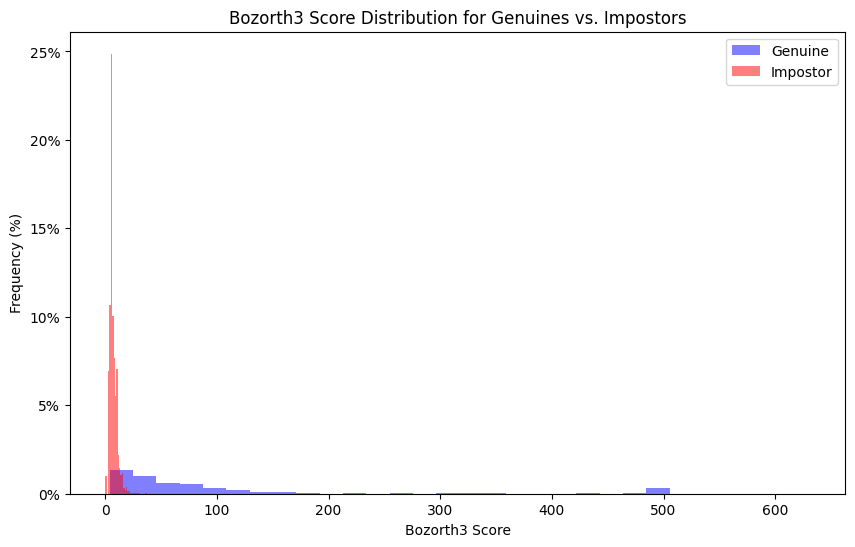

In [54]:
# Load the CSV containing Bozorth3 comparison results
csv_file = 'bozorth3_comparisons.csv'
data = pd.read_csv(csv_file)

# Classify the comparisons as genuine or impostor
genuine_scores = []
impostor_scores = []

for index, row in data.iterrows():
    file1 = row['File1']
    file2 = row['File2']
    score = row['Bozorth3_Score']
    
    # If file1 and file2 have the same root name, classify as genuine, otherwise impostor
    if file1.split('_')[0] == file2.split('_')[0]:
        genuine_scores.append(score)
    else:
        impostor_scores.append(score)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot histogram for genuine scores (normalized)
n_genuine, bins_genuine, patches_genuine = plt.hist(
    genuine_scores, bins=30, alpha=0.5, label='Genuine', color='blue', density=True
)

# Plot histogram for impostor scores (normalized)
n_impostor, bins_impostor, patches_impostor = plt.hist(
    impostor_scores, bins=30, alpha=0.5, label='Impostor', color='red', density=True
)

# Convert the y-axis to percentage by multiplying the density values by 100
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))

# Add labels and title
plt.xlabel('Bozorth3 Score')
plt.ylabel('Frequency (%)')
plt.title('Bozorth3 Score Distribution for Genuines vs. Impostors')

# Add legend
plt.legend()

# Show the plot
plt.show

## 3. Plot the similarity matrix of all the comparisons.

This code reads the Bozorth3 comparison results from a CSV file and creates a similarity matrix, where the rows and columns represent fingerprint images and the values indicate the Bozorth3 scores between them. Using the seaborn library, it visualizes this matrix as a heatmap, employing a color gradient to represent the similarity scores. The x-axis and y-axis labels are removed to eliminate file names for a cleaner presentation.

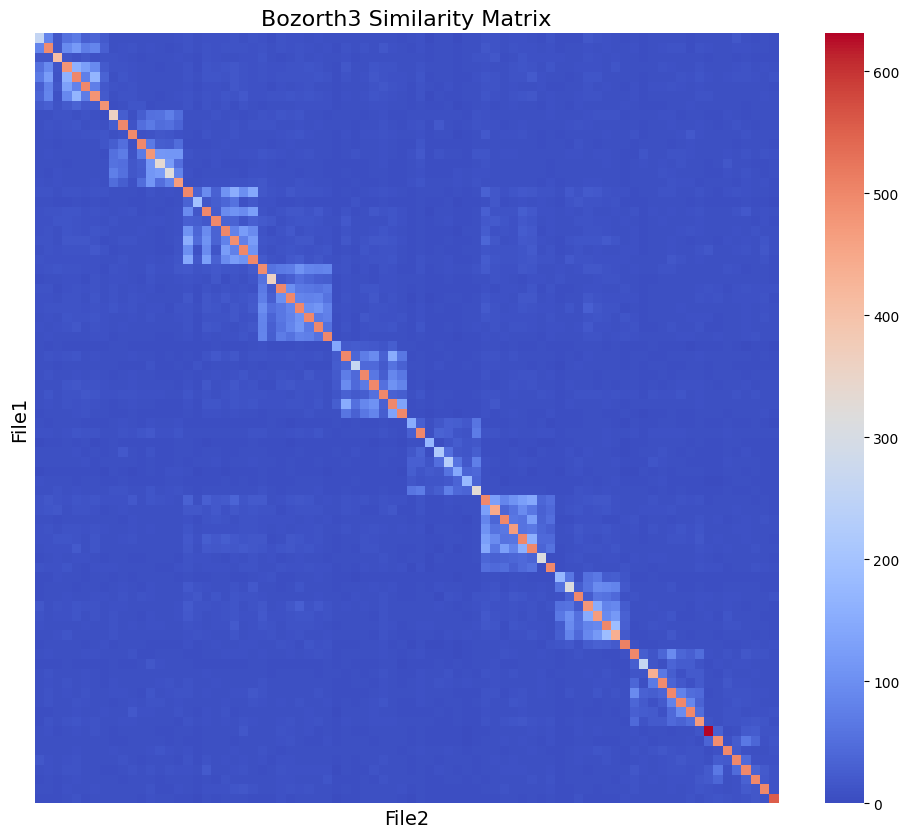

In [55]:
# Load the CSV file with Bozorth3 comparison results
csv_file = 'bozorth3_comparisons.csv'
data = pd.read_csv(csv_file)

# Create a pivot table (similarity matrix) where rows are File1, columns are File2, and values are Bozorth3_Score
similarity_matrix = data.pivot(index='File1', columns='File2', values='Bozorth3_Score')

# Plotting the similarity matrix
plt.figure(figsize=(12, 10))

# Use seaborn's heatmap to visualize the matrix
sns.heatmap(similarity_matrix, cmap='coolwarm', annot=False, cbar=True)

# Remove file names by setting empty labels on x and y axes
plt.xticks(ticks=[], labels=[])
plt.yticks(ticks=[], labels=[])

# Add titles and labels
plt.title('Bozorth3 Similarity Matrix', fontsize=16)
plt.xlabel('File2', fontsize=14)
plt.ylabel('File1', fontsize=14)

# Show the plot
plt.show()

## 4. Using nfiq (nfiq img.png), which gives you an estimate of fingerprint quality (1 is best, 5 is worst), plot the quality values of the fingerprints.

In this section, we will assess the quality of fingerprints using the NFIQ. The NFIQ scores range from 1 to 5, with 1 indicating the best quality and 5 the worst. We will process a set of PNG fingerprint images located in the specified directory, compute their NFIQ scores, and store these results in a CSV file for further analysis. After gathering the quality scores, we will calculate the frequency of each score and generate a bar plot to visualize the distribution of fingerprint qualities.

This Bash script iterates through all PNG files in the specified input directory, computes their NFIQ scores using the nfiq command, and records the filename along with its corresponding score in a CSV file. The generated CSV will serve as a basis for analyzing the quality distribution of the fingerprints.

```bash
#!/bin/bash

# Directory containing the PNG files
input_dir="DB1_B"

# Output file for storing the quality scores
quality_file="fingerprint_quality.csv"

# Write the header to the CSV
echo "Filename,NFIQ_Score" > "$quality_file"

# Loop through all .png files and compute NFIQ score
for img in "$input_dir"/*.png; do
  # Extract the filename without extension
  filename=$(basename "$img")
  
  # Get the NFIQ score
  score=$(nfiq "$img")
  
  # Write the filename and score to the CSV
  echo "$filename,$score" >> "$quality_file"
  
  echo "Processed $filename -> NFIQ Score: $score"
done

echo "All quality scores have been computed."
```

This code loads fingerprint quality scores from a CSV file and calculates the frequency of each NFIQ score, which ranges from 1 (best quality) to 5 (worst quality). It ensures that all possible scores from 1 to 5 are represented, even if some scores do not appear in the dataset. The code then generates a bar plot to visualize the frequency of each NFIQ score, with the x-axis labeled with the NFIQ scores and the y-axis representing their corresponding frequencies.

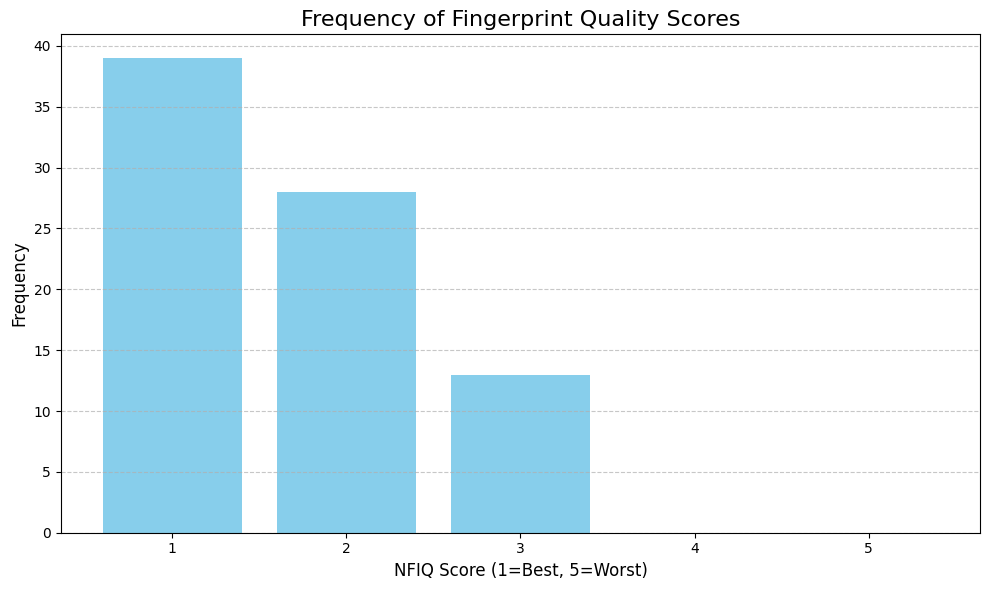

In [56]:
# Load the CSV file containing the NFIQ scores
quality_file = 'fingerprint_quality.csv'
quality_data = pd.read_csv(quality_file)

# Calculate the frequency of each NFIQ score
score_counts = quality_data['NFIQ_Score'].value_counts().sort_index()

# Ensure all NFIQ scores from 1 to 5 are included
all_scores = [1, 2, 3, 4, 5]
all_frequencies = [score_counts.get(score, 0) for score in all_scores]

# Plot the frequency values
plt.figure(figsize=(10, 6))

# Create a bar plot of the frequency of NFIQ scores
plt.bar(all_scores, all_frequencies, color='skyblue')

# Add labels and title
plt.xlabel('NFIQ Score (1=Best, 5=Worst)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency of Fingerprint Quality Scores', fontsize=16)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.xticks(all_scores)  # Ensure all scores from 1 to 5 are on the x-axis

# Show the plot
plt.tight_layout()
plt.show()

## 5. Determine the best threshold for bozorth3 outputs (to distinguish same or different subjects) as accurately as possible. Use an approach of your choosing.

This code implements an approach to determine the optimal threshold for distinguishing between genuine and impostor fingerprint scores using the Bozorth3 comparison results. The method calculates the False Acceptance Rate (FAR), which measures the proportion of impostor scores incorrectly classified as genuine, and the False Rejection Rate (FRR), which measures the proportion of genuine scores incorrectly classified as impostors. By evaluating these rates across a range of thresholds, the code identifies the Equal Error Rate (EER), where FAR and FRR are equal, indicating the most balanced threshold for classification. The results are visualized in a plot showing the FAR and FRR as functions of the threshold, with the EER threshold and value highlighted. The calculated EER threshold and value are then printed for reference.

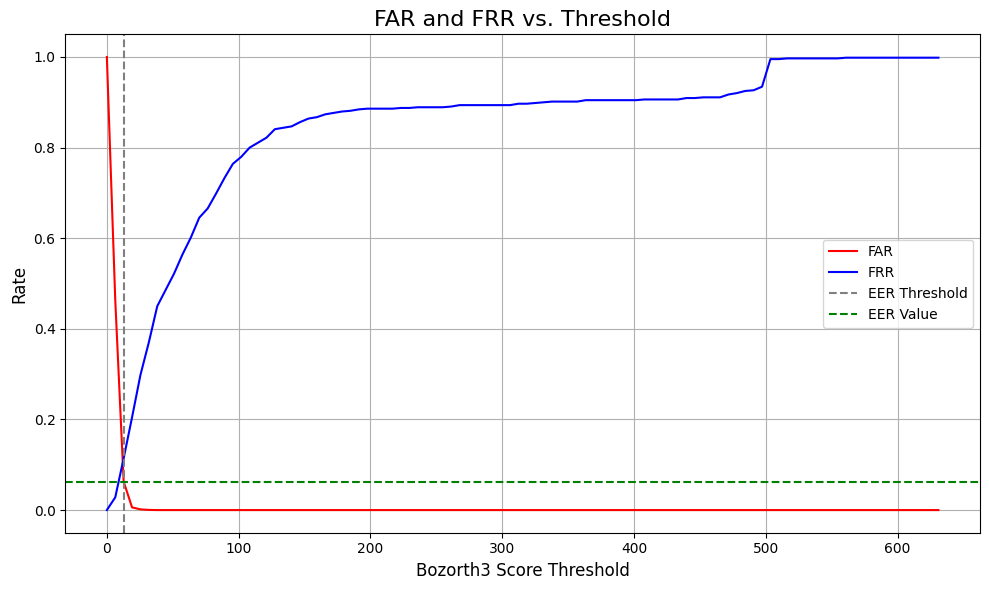

EER Threshold: 12.75
EER Value: 0.06


In [57]:
# Convert lists to numpy arrays for calculations
genuine_scores = np.array(genuine_scores)
impostor_scores = np.array(impostor_scores)

# Define thresholds and initialize FAR and FRR lists
thresholds = np.linspace(min(impostor_scores), max(genuine_scores), num=100)
FAR = []
FRR = []

# Calculate FAR and FRR for each threshold
for threshold in thresholds:
    # FAR: Proportion of impostor scores above the threshold
    far = np.sum(impostor_scores >= threshold) / len(impostor_scores)
    FAR.append(far)
    
    # FRR: Proportion of genuine scores below the threshold
    frr = np.sum(genuine_scores < threshold) / len(genuine_scores)
    FRR.append(frr)

# Convert lists to numpy arrays
FAR = np.array(FAR)
FRR = np.array(FRR)

# Find the EER
eer_index = np.argmin(np.abs(FAR - FRR))  # Find the index of the minimum difference
eer_threshold = thresholds[eer_index]
eer_value = FAR[eer_index]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, FAR, label='FAR', color='red')
plt.plot(thresholds, FRR, label='FRR', color='blue')
plt.axvline(x=eer_threshold, linestyle='--', color='gray', label='EER Threshold')
plt.axhline(y=eer_value, linestyle='--', color='green', label='EER Value')
plt.xlabel('Bozorth3 Score Threshold', fontsize=12)
plt.ylabel('Rate', fontsize=12)
plt.title('FAR and FRR vs. Threshold', fontsize=16)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Print the EER information
print(f"EER Threshold: {eer_threshold:.2f}")
print(f"EER Value: {eer_value:.2f}")


## 6. Perform classification and report classification accuracy (the number of correctly classified pairs divided by the number of all comparisons). Do this by comparing all samples only once; no comparisons with themselves or repeated comparisons (i.e., do only A vs. B, and no B vs. A, A vs. A, B vs. B), and checking whether their class annotations match or not.

This code loads fingerprint comparison results from a CSV file and classifies each unique pair of fingerprints as either genuine or impostor based on a predetermined threshold derived from earlier analysis (such as the Equal Error Rate). It iterates through the comparisons, ensuring that each pair is only evaluated once by using a set to track unique pair identifiers. The code checks if the Bozorth3 score for each pair indicates a match or mismatch and counts the number of correct classifications. Finally, it calculates and prints the classification accuracy, representing the proportion of correctly identified pairs relative to the total comparisons made.

In [58]:
# Load comparison results and labels
comparison_file = 'bozorth3_comparisons.csv'
comparison_data = pd.read_csv(comparison_file)

# Define the threshold for classification based on EER or another criterion
threshold = eer_threshold  # Use the threshold found in the previous step

# Initialize counters for correct classifications
correct_count = 0
total_count = 0

# Create a set to keep track of unique comparisons (A vs. B)
unique_comparisons = set()

# Iterate through the comparisons
for index, row in comparison_data.iterrows():
    file1 = row['File1']
    file2 = row['File2']
    score = row['Bozorth3_Score']
    
    # Create a unique pair identifier (to avoid A vs. B and B vs. A)
    pair_id = tuple(sorted([file1, file2]))
    
    if pair_id not in unique_comparisons:
        unique_comparisons.add(pair_id)
        total_count += 1
        
        # Check if the score indicates a match or mismatch
        # Assuming 'genuine' if file names are similar (for example, same prefix)
        is_genuine = file1.split('_')[0] == file2.split('_')[0]
        
        # Classification based on the threshold
        if (score >= threshold and is_genuine) or (score < threshold and not is_genuine):
            correct_count += 1

# Calculate accuracy
accuracy = correct_count / total_count if total_count > 0 else 0

# Report the accuracy
print(f'Classification Accuracy: {accuracy:.2%}')


Classification Accuracy: 93.33%


## 7. Modify the classification so that you first classify each fingerprint by its type (A = Arch, L = Left Loop,R = Right Loop,S = Scar,T = Tented Arch, W = Whorl), and then only match within this sub-group. To do this, call pcasys pcasys.prs.

We first converted the PNG image to WSQ format using a custom script. The script begins by converting the input PNG file into an 8-bit grayscale image using ImageMagick. This grayscale image is then compressed into WSQ format using `cwsq` with specified image dimensions (640x480), bit depth (8), and a DPI of 500, which meets PCASYS requirements. Once the WSQ image is ready, minutiae (fingerprint details) are extracted using the `mindtct` command. After preparing the images, we ran `pcasys pcasys.prs` to classify the fingerprints.

```bash
#!/bin/bash

# Convert $1.png to a grayscale image and save as $1.gray
magick "$1.png" -depth 8 -type Grayscale -compress none -colorspace Gray -strip "$1.gray"

# Create WSQ from the RAW image, -raw_in W,H,bits,DPI, just keep in mind that pcasys needs more than 300
cwsq 0.75 wsq "$1.gray" -raw_in 640,480,8,500

# Compute minutiae on WSQ
mindtct "$1.wsq" "$1"
```

```bash
101_1.wsq: is A; nn: hyp R, conf 0.57; conup n; hyp R, conf 0.57; wrong
101_2.wsq: is A; nn: hyp R, conf 0.61; conup n; hyp R, conf 0.61; wrong
101_3.wsq: is A; nn: hyp R, conf 0.45; conup n; hyp R, conf 0.45; wrong
101_4.wsq: is A; nn: hyp R, conf 0.31; conup n; hyp R, conf 0.31; wrong
101_5.wsq: is A; nn: hyp R, conf 0.65; conup n; hyp R, conf 0.65; wrong
101_6.wsq: is A; nn: hyp R, conf 0.60; conup n; hyp R, conf 0.60; wrong
101_7.wsq: is A; nn: hyp L, conf 0.32; conup n; hyp L, conf 0.32; wrong
101_8.wsq: is A; nn: hyp R, conf 0.31; conup n; hyp R, conf 0.31; wrong
102_1.wsq: is A; nn: hyp R, conf 0.68; conup n; hyp R, conf 0.68; wrong
102_2.wsq: is A; nn: hyp R, conf 1.00; conup n; hyp R, conf 1.00; wrong
102_3.wsq: is A; nn: hyp R, conf 0.92; conup n; hyp R, conf 0.92; wrong
102_4.wsq: is A; nn: hyp R, conf 0.98; conup n; hyp R, conf 0.98; wrong
102_5.wsq: is A; nn: hyp R, conf 1.00; conup n; hyp R, conf 1.00; wrong
102_6.wsq: is A; nn: hyp R, conf 0.99; conup n; hyp R, conf 0.99; wrong
102_7.wsq: is A; nn: hyp R, conf 1.00; conup n; hyp R, conf 1.00; wrong
102_8.wsq: is A; nn: hyp R, conf 0.81; conup n; hyp R, conf 0.81; wrong
103_1.wsq: is A; nn: hyp L, conf 0.95; conup n; hyp L, conf 0.95; wrong
103_2.wsq: is A; nn: hyp L, conf 0.96; conup n; hyp L, conf 0.96; wrong
103_3.wsq: is A; nn: hyp L, conf 1.00; conup n; hyp L, conf 1.00; wrong
103_4.wsq: is A; nn: hyp L, conf 0.98; conup n; hyp L, conf 0.98; wrong
103_5.wsq: is A; nn: hyp L, conf 1.00; conup n; hyp L, conf 1.00; wrong
103_6.wsq: is A; nn: hyp L, conf 1.00; conup n; hyp L, conf 1.00; wrong
103_7.wsq: is A; nn: hyp L, conf 1.00; conup n; hyp L, conf 1.00; wrong
103_8.wsq: is A; nn: hyp L, conf 0.97; conup n; hyp L, conf 0.97; wrong
104_1.wsq: is A; nn: hyp L, conf 0.92; conup n; hyp L, conf 0.92; wrong
104_2.wsq: is A; nn: hyp L, conf 0.93; conup n; hyp L, conf 0.93; wrong
104_3.wsq: is A; nn: hyp L, conf 0.99; conup n; hyp L, conf 0.99; wrong
104_4.wsq: is A; nn: hyp L, conf 0.98; conup n; hyp L, conf 0.98; wrong
104_5.wsq: is A; nn: hyp L, conf 0.96; conup n; hyp L, conf 0.96; wrong
104_6.wsq: is A; nn: hyp L, conf 1.00; conup n; hyp L, conf 1.00; wrong
104_7.wsq: is A; nn: hyp L, conf 1.00; conup n; hyp L, conf 1.00; wrong
104_8.wsq: is A; nn: hyp L, conf 1.00; conup n; hyp L, conf 1.00; wrong
105_1.wsq: is A; nn: hyp L, conf 0.65; conup n; hyp L, conf 0.65; wrong
105_2.wsq: is A; nn: hyp L, conf 0.97; conup n; hyp L, conf 0.97; wrong
105_3.wsq: is A; nn: hyp L, conf 0.98; conup n; hyp L, conf 0.98; wrong
105_4.wsq: is A; nn: hyp L, conf 0.93; conup n; hyp L, conf 0.93; wrong
105_5.wsq: is A; nn: hyp L, conf 1.00; conup n; hyp L, conf 1.00; wrong
105_6.wsq: is A; nn: hyp L, conf 0.97; conup n; hyp L, conf 0.97; wrong
105_7.wsq: is A; nn: hyp L, conf 0.99; conup n; hyp L, conf 0.99; wrong
105_8.wsq: is A; nn: hyp L, conf 0.97; conup n; hyp L, conf 0.97; wrong
106_1.wsq: is A; nn: hyp R, conf 0.96; conup n; hyp R, conf 0.96; wrong
106_2.wsq: is A; nn: hyp R, conf 0.99; conup n; hyp R, conf 0.99; wrong
106_3.wsq: is A; nn: hyp R, conf 0.99; conup n; hyp R, conf 0.99; wrong
106_4.wsq: is A; nn: hyp R, conf 0.99; conup n; hyp R, conf 0.99; wrong
106_5.wsq: is A; nn: hyp R, conf 0.46; conup n; hyp R, conf 0.46; wrong
106_6.wsq: is A; nn: hyp R, conf 0.99; conup n; hyp R, conf 0.99; wrong
106_7.wsq: is A; nn: hyp R, conf 1.00; conup n; hyp R, conf 1.00; wrong
106_8.wsq: is A; nn: hyp R, conf 0.99; conup n; hyp R, conf 0.99; wrong
107_1.wsq: is A; nn: hyp L, conf 0.99; conup n; hyp L, conf 0.99; wrong
107_2.wsq: is A; nn: hyp L, conf 1.00; conup n; hyp L, conf 1.00; wrong
107_3.wsq: is A; nn: hyp L, conf 1.00; conup n; hyp L, conf 1.00; wrong
107_4.wsq: is A; nn: hyp L, conf 0.99; conup n; hyp L, conf 0.99; wrong
107_5.wsq: is A; nn: hyp L, conf 0.98; conup n; hyp L, conf 0.98; wrong
107_6.wsq: is A; nn: hyp L, conf 1.00; conup n; hyp L, conf 1.00; wrong
107_7.wsq: is A; nn: hyp L, conf 0.97; conup n; hyp L, conf 0.97; wrong
107_8.wsq: is A; nn: hyp L, conf 0.99; conup n; hyp L, conf 0.99; wrong
108_1.wsq: is A; nn: hyp L, conf 0.89; conup n; hyp L, conf 0.89; wrong
108_2.wsq: is A; nn: hyp L, conf 0.90; conup n; hyp L, conf 0.90; wrong
108_3.wsq: is A; nn: hyp L, conf 0.97; conup n; hyp L, conf 0.97; wrong
108_4.wsq: is A; nn: hyp L, conf 0.99; conup n; hyp L, conf 0.99; wrong
108_5.wsq: is A; nn: hyp L, conf 0.98; conup n; hyp L, conf 0.98; wrong
108_6.wsq: is A; nn: hyp L, conf 1.00; conup n; hyp L, conf 1.00; wrong
108_7.wsq: is A; nn: hyp L, conf 1.00; conup n; hyp L, conf 1.00; wrong
108_8.wsq: is A; nn: hyp L, conf 1.00; conup n; hyp L, conf 1.00; wrong
109_1.wsq: is A; nn: hyp W, conf 1.00; conup y; hyp W, conf 1.00; wrong
109_2.wsq: is A; nn: hyp W, conf 0.85; conup y; hyp W, conf 1.00; wrong
109_3.wsq: is A; nn: hyp W, conf 1.00; conup y; hyp W, conf 1.00; wrong
109_4.wsq: is A; nn: hyp W, conf 1.00; conup y; hyp W, conf 1.00; wrong
109_5.wsq: is A; nn: hyp W, conf 1.00; conup y; hyp W, conf 1.00; wrong
109_6.wsq: is A; nn: hyp W, conf 0.99; conup y; hyp W, conf 1.00; wrong
109_7.wsq: is A; nn: hyp W, conf 1.00; conup y; hyp W, conf 1.00; wrong
109_8.wsq: is A; nn: hyp W, conf 0.94; conup y; hyp W, conf 1.00; wrong
110_1.wsq: is A; nn: hyp W, conf 0.99; conup y; hyp W, conf 1.00; wrong
110_2.wsq: is A; nn: hyp W, conf 0.90; conup y; hyp W, conf 1.00; wrong
110_3.wsq: is A; nn: hyp W, conf 0.98; conup y; hyp W, conf 1.00; wrong
110_4.wsq: is A; nn: hyp W, conf 0.93; conup y; hyp W, conf 1.00; wrong
110_5.wsq: is A; nn: hyp W, conf 0.83; conup y; hyp W, conf 1.00; wrong
110_6.wsq: is A; nn: hyp W, conf 0.87; conup y; hyp W, conf 1.00; wrong
110_7.wsq: is A; nn: hyp W, conf 0.76; conup y; hyp W, conf 1.00; wrong
110_8.wsq: is A; nn: hyp W, conf 0.94; conup y; hyp W, conf 1.00; wrong

pct error: 100.00

          A           L           R           S           T           W 
A     0(  0.0)   41( 51.2)   23( 28.8)    0(  0.0)    0(  0.0)   16( 20.0)
L     0(  -  )    0(  -  )    0(  -  )    0(  -  )    0(  -  )    0(  -  )
R     0(  -  )    0(  -  )    0(  -  )    0(  -  )    0(  -  )    0(  -  )
S     0(  -  )    0(  -  )    0(  -  )    0(  -  )    0(  -  )    0(  -  )
T     0(  -  )    0(  -  )    0(  -  )    0(  -  )    0(  -  )    0(  -  )
W     0(  -  )    0(  -  )    0(  -  )    0(  -  )    0(  -  )    0(  -  )

```

Instances were identified as various types, predominantly as 'L' (41 instances) and 'R' (23 instances), along with a few classifications as 'W' (16 instances). Notably, none of the true 'A' classifications were recognized.

The code below processes fingerprint classification results, grouping images based on their predicted classes. It reads a log file (`pcasys.out`) to extract image names and their predicted classifications using a regex pattern. The code then loads comparison data from a CSV file containing scores for pairs of images. It checks if the pairs belong to the same predicted class and whether their names indicate they are genuine matches (same prefix). Using a predefined threshold, it counts the correct classifications and calculates the accuracy.

In [70]:
import re
import pandas as pd
from collections import defaultdict

# Initialize a dictionary to store images grouped by their classification
grouped_images = defaultdict(list)
image_class_map = {}

# Read the pcasys.out file
with open('pcasys.out', 'r') as file:
    lines = file.readlines()

# Regex pattern to extract the image name and predicted class (hyp X)
pattern = re.compile(r'(\d+_\d+\.wsq): .*hyp (\w)')

# Iterate through each line in the file
for line in lines:
    match = pattern.search(line)
    if match:
        # Extract the image file name and its predicted class
        image_name = match.group(1)
        predicted_class = match.group(2)
        
        # Add the image to the respective class group
        grouped_images[predicted_class].append(image_name)
        
        # Create a mapping from image name to its predicted class
        image_class_map[image_name] = predicted_class

# Load comparison results and labels
comparison_file = 'bozorth3_comparisons.csv'
comparison_data = pd.read_csv(comparison_file)

# Define the threshold for classification based on EER or another criterion
threshold = eer_threshold  # Use the threshold found in the previous step

# Initialize counters for correct classifications
correct_count = 0
total_count = 0

# Create a set to keep track of unique comparisons (A vs. B)
unique_comparisons = set()

# Iterate through the comparisons
for index, row in comparison_data.iterrows():
    file1 = row['File1']
    file2 = row['File2']
    score = row['Bozorth3_Score']
    
    # Check if the images belong to the same predicted class, the file1 and file2 are xyt files and not wsq
    # Get only the name of the files
    file1_name = file1.split('.')[0] + ".wsq"
    file2_name = file2.split('.')[0] + ".wsq"
    
    # Check if the images belong to the same predicted class
    same_class = image_class_map.get(file1_name) == image_class_map.get(file2_name)
    
    
    # If not in the same class, skip
    if not same_class:
        continue
    
    # Create a unique pair identifier (to avoid A vs. B and B vs. A)
    pair_id = tuple(sorted([file1, file2]))
    
    if pair_id not in unique_comparisons:
        unique_comparisons.add(pair_id)
        total_count += 1
        
        # Check if the score indicates a match or mismatch
        # Assuming 'genuine' if file names are similar (for example, same prefix)
        is_genuine = file1.split('_')[0] == file2.split('_')[0]
        
        # Classification based on the threshold
        if (score >= threshold and is_genuine) or (score < threshold and not is_genuine):
            correct_count += 1

# Calculate accuracy
accuracy = correct_count / total_count if total_count > 0 else 0

# Report the accuracy
print(f'Classification Accuracy: {accuracy:.2%}')

Classification Accuracy: 87.35%


The final result of 87.35% indicates that the classification was more accurate when images were not first categorized into types, suggesting that the model's performance improves when evaluated directly on raw score comparisons.